<a href="https://colab.research.google.com/github/seraffin/FailOmen/blob/master/Wojtek/NNOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PREPARATIONS:

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
# import keras

# Helper libraries
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving convertMinidataToML.csv to convertMinidataToML.csv
User uploaded file "convertMinidataToML.csv" with length 1154382 bytes


#**UTILITIES:**

##Optimizer:

In [0]:
#@title
def optimizer(func, steps, minMax1, minMax2=False, split = 4, reduceSplit = False, searchMaximum = True):
  """
  -------------------------------
  Function can take 1 or 2 parameters to optimization.
  Default: 2 parameters (you need to set values for minMax1 and minMax2)
           For 1 parameter optimization set argument: "minMax2 = False"

  -------------------------------
  func        -->  enter your function there
                   IMPORTANT:
                   * if function has 1 parameter:  minMax1 = [min, max],   minMax2 = False
                   * if function has 2 parameters: minMax1 = [min1, max1], minMax2 = [min2, max2]
                   
  steps       -->  number of iterations of recurency
  
  minMax1/2   -->  list of min and max value of parameters to begin with (ex. [min, max])
  
  split        -->  number of parts in which function will split values of parameters
                   higher value -> better accuracy & longer calculation time
                   (Values range 2 -- 10)
                   
  reduceSplit -->  If True: with every repetition of recurency will reduce split by one
  
  -------------------------------
  """
  import matplotlib.pyplot as plt
  import math
  
  
  plotData = []
  iterationCounter = 0
  iterationsLeft = steps
  recurencyCounter = 0
  bestResult = None
  print(iterationsLeft)
  
  #--------------------

  def returnStepList(minValue, maxValue, nrSteps):
      step = math.fabs(maxValue - minValue)/nrSteps
      actualMin = min([minValue, maxValue])
      actualMax = max([minValue, maxValue])
      return [actualMin + step*nr for nr in range(nrSteps + 1)]

  def resetIterators():
    global plotData
    global iterationCounter
    global recurencyCounter
    plotData = []
    iterationCounter = 0
    recurencyCounter = 0


  def create_plot_optimizer(x_data, y_data=0, xLabel = 'X', yLabel = 'Y'):
      import matplotlib.pyplot as plt
      if y_data == 0:  
          unzip = list(zip(*x_data))
          x_data, y_data = unzip[0],unzip[1]
      plt.plot(x_data, y_data)
      plt.xlabel(xLabel)
      plt.ylabel(yLabel)
      plt.show()


  def optimize(func, steps, minMax1, minMax2 = False, split = 4, reduceSplit = False, 
               searchMaximum = True, iLeft = None):
      
      global resetIterators
      global iterationCounter
      global iterationsLeft
      global recurencyCounter
      global bestResult
      
      localICounter = 0
      iL = iLeft
      sMax = searchMaximum
      singleParam = False
      bestPair = [None, None]
      resultList = []
      parametersList=[]

      if reduceSplit is False:
        newSplit = split
      else:
        if split > 2:
          newSplit = split - 1
        else:
          newSplit = 2
      if split > 10:
        raise ValueError("Too big value of 'split' parameter! This would highly increase number of iterations")
      if minMax2 is False:
        singleParam = True

      recurencyCounter += 1

      if isinstance(minMax1, list) and (isinstance(minMax2, list) or singleParam) :

          stepList1 = returnStepList(minMax1[0], minMax1[1], split)
          if singleParam:
            stepList2 = [1]
          else:
            stepList2 = returnStepList(minMax2[0], minMax2[1], split)
          
          nrIterations = len(stepList1)*len(stepList2)
          i1 = 0
          i2 = 0



          for el1 in stepList1:
              i2 = 0
              for el2 in stepList2:
                  iterationCounter += 1
                  localICounter += 1
                  print("---Iteration: {0}/{1} ----Recurency: {2}/{3}".format(localICounter, 
                                                              nrIterations,
                                                              recurencyCounter,
                                                              iL))

                  #----function----
                  if singleParam:
                    evaluation = func(el1)
                  else:
                    evaluation = func(el1, el2)
                  #----function----

                  if len(resultList) > 0:
                      #----condition----
                      if sMax:
                        if evaluation >= max(resultList):
                            bestPair[0] = i1
                            bestPair[1] = i2
                      else:
                        if evaluation <= min(resultList):
                            bestPair[0] = i1
                            bestPair[1] = i2

                      #----condition----

                  else:
                    if singleParam:
                      bestPair[0] = i1
                    else:
                      bestPair[0] = i1
                      bestPair[1] = i2

                  plotData.append([evaluation, iterationCounter])

                  resultList.append(evaluation)
                  if singleParam:
                    parametersList.append([el1])
                  else:
                    parametersList.append([el1, el2])

                  i2 += 1
              i1 += 1

          #------------------------------------------------


          if bestPair[0] == stepList1.index(stepList1[0]):
              minMax1[0] = stepList1[bestPair[0]]/2
              minMax1[1] = stepList1[bestPair[0] + 1]
  #                 print("best values of PARAM_1 are close to MIN value")

          elif bestPair[0] == stepList1.index(stepList1[-1]):
              minMax1[0] = stepList1[bestPair[0] - 1]
              minMax1[1] = stepList1[bestPair[0]]*2
  #                 print("best values of PARAM_1 are close to MAX value")


          else:
              minMax1[0] = stepList1[bestPair[0] - 1]
              minMax1[1] = stepList1[bestPair[0] + 1]

          #------------------------------------------------
          if not singleParam:
            if bestPair[1] == stepList2.index(stepList2[0]):
                minMax2[0] = stepList1[bestPair[1]]/2
                minMax2[1] = stepList1[bestPair[1] + 1]
  #                 print("best values of PARAM_2 are close to MIN value")

            elif bestPair[1] == stepList2.index(stepList2[-1]):
                minMax2[0] = stepList1[bestPair[1] - 1]
                minMax2[1] = stepList1[bestPair[1]]*2
  #                 print("best values of PARAM_2 are close to MAX value")


            else:
                minMax2[0] = stepList2[bestPair[1] - 1]
                minMax2[1] = stepList2[bestPair[1] + 1]

          #------------------------------------------------
          if sMax:
            result = max(resultList)
            param1 = parametersList[resultList.index(max(resultList))][0]
            if not singleParam:
              param2 = parametersList[resultList.index(max(resultList))][1]
          else:
            result = min(resultList)
            param1 = parametersList[resultList.index(min(resultList))][0]
            if not singleParam:
              param2 = parametersList[resultList.index(min(resultList))][1]
                    
          if steps > 0:
            if singleParam:
              print("---------------------------------------------------------\n")
              optimize(func,
                       steps - 1,
                       [minMax1[0],minMax1[1]],
                       minMax2 = False,
                       split = newSplit,
                       reduceSplit=reduceSplit,
                       searchMaximum = sMax,
                       iLeft = iL )
            else:
              print("---------------------------------------------------------\n")
              optimize(func,
                       steps - 1,
                       [minMax1[0], minMax1[1]],
                       minMax2=[minMax2[0], minMax2[1]],
                       split = newSplit,
                       reduceSplit=reduceSplit,
                       searchMaximum = sMax,
                       iLeft = iL)
            
          else:
            if singleParam:
              print('\n------------------ACHIEVED RESULTS------------------\n')
              print("{:<20}{}\n{:<20}{}\n".format('RESULT: ',
                                                  result,
                                                  'PARAMETER 1: ',
                                                  param1))
              return [result, param1]
            else:
              print('\n------------------ACHIEVED RESULTS------------------\n')
              print("{:<20}{}\n{:<20}{}\n{:<20}{}\n".format('RESULT: ',
                                                            result,
                                                            'PARAMETER 1: ',
                                                            param1,
                                                            'PARAMETER 2: ',
                                                            param2))
              return [result, param1, param2]

      else:
          print("enter correct value!")
         
  resetIterators()
  result = optimize(func,
                    steps,
                    minMax1,
                    minMax2,
                    split,
                    reduceSplit,
                    searchMaximum = searchMaximum,
                    iLeft = steps+1)
  xData = [num[1] for num in plotData]
  yData = [num[0] for num in plotData]
  create_plot_optimizer(xData, yData, 'Iterations', 'Result')
  return result


12
---Iteration: 1/11 ----Recurency: 1/13
---Iteration: 2/11 ----Recurency: 1/13
---Iteration: 3/11 ----Recurency: 1/13
---Iteration: 4/11 ----Recurency: 1/13
---Iteration: 5/11 ----Recurency: 1/13
---Iteration: 6/11 ----Recurency: 1/13
---Iteration: 7/11 ----Recurency: 1/13
---Iteration: 8/11 ----Recurency: 1/13
---Iteration: 9/11 ----Recurency: 1/13
---Iteration: 10/11 ----Recurency: 1/13
---Iteration: 11/11 ----Recurency: 1/13
---------------------------------------------------------

---Iteration: 1/10 ----Recurency: 2/13
---Iteration: 2/10 ----Recurency: 2/13
---Iteration: 3/10 ----Recurency: 2/13
---Iteration: 4/10 ----Recurency: 2/13
---Iteration: 5/10 ----Recurency: 2/13
---Iteration: 6/10 ----Recurency: 2/13
---Iteration: 7/10 ----Recurency: 2/13
---Iteration: 8/10 ----Recurency: 2/13
---Iteration: 9/10 ----Recurency: 2/13
---Iteration: 10/10 ----Recurency: 2/13
---------------------------------------------------------

---Iteration: 1/9 ----Recurency: 3/13
---Iteration: 2/9 -

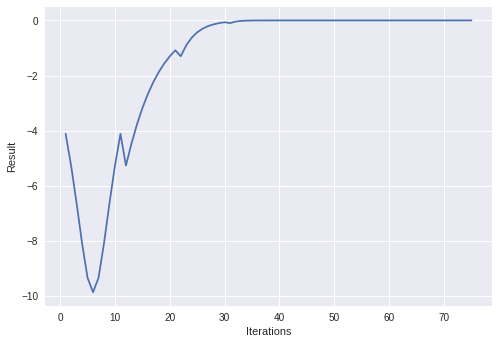

In [3]:
#@title
def exampleFunction(x, y = 5):
  return ((-20)* math.exp((((0.5*(x**2 + y**2))**0.5)*(-0.2))))


optimizer(exampleFunction, 12 , [-10,10], minMax2=False,  split = 10, reduceSplit = True, searchMaximum = True)


##**Other:**

In [0]:
#@title
def searchForFailed(yList):
    changedRowList = []
    for row in range (len(yList)):
        if 0 in yList[row]:
            changedRowList.append(row)
    return changedRowList

def returnFailedData(xList, yList, changedRowList):
    xFailed = []
    yFailed = []
  
    for row in changedRowList:
        xFailed.append(xList[row])
        yFailed.append(yList[row])
    xFailed = np.array(xFailed)
    yFailed = np.array(yFailed)
    return xFailed, yFailed



In [0]:
#@title
def count_distribution(prediction):
    #Distributions of argmins through all the predictions
    i = 1
    tab = [0] * 542
    for a in prediction:
        j = 0
        for b in a:
            if b < 1.0 : j = j + 1

        #print (i, '. ', j, np.argmin(a))
        tab[np.argmin(a)] += 1
        i = i + 1

    i = 0
    distributed_array = []
    for a in tab:
        if a > 0 : 
            #print ('position', i, '\targmin count', a)
            distributed_array.append((i,a))
        i += 1
    create_plot(distributed_array)  
    return distributed_array


In [0]:
#@title
def failsCount():
    fala = 0
    for i, a in enumerate(yTest):
        j = 0
        for k, b in enumerate(a):
            if b < 1.0 : j += 1

        if j > 0 : 
            print (i, '. ', j)
        i = i + 1
        fala += j
    print (fala)

In [0]:
#@title
# Evaluation function

def evaluation(additionalPredictions, refYsupervisor, predictions):

    lenght = len(refYsupervisor)

    failPositions = [[] for y in range(lenght)]

  
    for i, a in enumerate(refYsupervisor):

        for j, b in enumerate(a):
            if b == 0 : failPositions[i].append(j);

    predictionsTemp = predictions.copy()
    predictionPositions = [[] for y in range(lenght)]


    for i, a in enumerate(predictionsTemp):

        if len(failPositions[i]) != 0:
            for j in range(len(failPositions[i]) + additionalPredictions):
                argmin = np.argmin(a)
                predictionPositions[i].append(argmin)
                predictionsTemp[i][argmin] = 1

    predictionHits = [[] for y in range(lenght)]

    for i, a in enumerate(failPositions):
        count = 0
        for j, b in enumerate(a):


            for c in predictionPositions[i]:
  #      predictionHits[i].append(predictions[i][c].copy())
  #      print(predictions[i][c])
  #      print(predictions[i][c])
  #      print (b, c)
                if c == b : count += 1

        if len(failPositions) != 0:
            predictionHits[i].insert(0,count)


    failsCount = 0
    hitsCount = 0
    for i, a in enumerate(refYsupervisor):
        j = 0

        for k, b in enumerate(a):
            if b < 1.0 : j += 1

  #  if j > 0 :
  #    print (i, '.', j, predictionHits[i])


        failsCount += j
        hitsCount += predictionHits[i][0]
    
    percFailsPredicted = hitsCount / failsCount * 100
    print('Percentage of fails predicted', hitsCount / failsCount * 100, '%')
    return percFailsPredicted

#**NEURAL NETWORK:**

##Data:

In [0]:
#Importing dataset
dataset = pd.read_csv('dataToML_newConcept.csv', index_col=False)

#Check the first 5 rows of the dataset. 
dataset.head(5)

In [0]:
x = dataset.iloc[:, 0:23739].values
y = dataset.iloc[:, 23739:24281].values

In [0]:
xReduced, yReduced = returnFailedData(x, y, searchForFailed(y))

In [0]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(xReduced, yReduced, test_size = 0.2)


##Model definition:

In [0]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

# Adding the input layer and the output layer
model.add(Dense(units = 542, activation="sigmoid", input_dim=23739, kernel_initializer="uniform")) # TRY smaller input_dim value or less neurons

In [0]:
model.compile(optimizer = tf.train.MomentumOptimizer(learning_rate = 0.01, momentum = 0.4), loss = 'binary_crossentropy', metrics = ['accuracy'])
 
model.fit(xTrain, yTrain, batch_size = 10, epochs = 2)

In [0]:
def calculateNetwork(x):
    inputUnits = int(x)
    firstLayerUnits = int(x)
    secondLayerUnits = int(x)
    if not isinstance(inputUnits, (int)) or not isinstance(firstLayerUnits, (int)) or not isinstance(secondLayerUnits, (int)):
        print("Enter correct input!")\

    else:
        pBatchSize = 10
        pEpochs = 1
        pLearningRate = 0.01
        pMomentum = 0.04
  
        model = Sequential()

        # Adding the input layer and the first hidden layer
        model.add(Dense(inputUnits, activation="sigmoid", input_dim=23739, kernel_initializer="uniform")) # TRY smaller input_dim value or less neurons
        # Adding the second hidden layer
        model.add(Dense(firstLayerUnits, activation = "sigmoid", kernel_initializer="uniform"))
        # Adding the output layer
        model.add(Dense(secondLayerUnits, activation="sigmoid", kernel_initializer="uniform"))
  
  
        model.compile(optimizer = tf.train.MomentumOptimizer(learning_rate = pLearningRate, momentum = pMomentum), loss = 'binary_crossentropy', metrics = ['accuracy'])
        model.fit(xTrain, yTrain, batch_size = pBatchSize, epochs = pEpochs)
  
        predictions = model.predict(xReduced)
        evaluationResult = evaluation(15, yReduced, predictions)
        predictionArray.append(evaluationResult)
        return evaluationResult
    
